In [ ]:
# RGBchannel을 그대로 입력받는 모델을 구현
# filter number에 대한 실험 결과 참고 -> n1=128, n2=64, n3=3 ;; n-각 convolution layer의 필터 숫자
# filter size에 대한 실험 결과 참고 -> f1=9, f2=3, f3=5 ;; f-filter size
# 순서대로 ReLU, 마지막은 Linear
# 논문 조건대로 weight : Xaiver 정규 분포, bias : 제로 벡터로 초기화
# learning rate -> 0.003 일괄 통일
# SRCNN의 저해상도 이미지 -> 고해상도 이미지를 Random crop -> Bicubic보간법으로 upscaling된 이미지
# kaggle에 91 Images활용 // https://www.kaggle.com/datasets/ll01dm/t91-image-dataset
# 검증 데이터도 논문과 동일한 set5 // https://www.kaggle.com/datasets/ll01dm/set-5-14-super-resolution-dataset

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py #(?)
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, Input
from keras import initializers
from keras.optimizers import Adam
import random

# 얘네 3줄은 뭐지?
import cv2
import os
from glob import glob  ## glob는 데이터셋이 저장된 path에서 '.png'로 끝나는 파일의 목록 반환

In [3]:
# connecting Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
!pwd # current position

/content


In [ ]:
%cd /content/drive/MyDrive/

In [ ]:
!mkdir srcnn

In [ ]:
%cd /content/drive/srcnn

In [ ]:
!pwd # current position

In [ ]:
%cd /content/drive/MyDrive/srcnn


In [ ]:
# 파라미터 선언
# path : 91 image dataset 저장 경로
# save_path : 최종 모델의 가중치 저장 경로

In [5]:
n1, n2, n3 = 128, 64, 3
f1, f2, f3 = 9, 3, 5
upscale_factor = 2

input_size = 33
output_size = input_size - f1 - f2 - f3 + 3
pad = abs(input_size - output_size) // 2
stride = 14

batch_size = 128
epochs = 200

In [6]:
path = '/content/drive/MyDrive/srcnn/T91'
save_path = '/content/drive/MyDrive/srcnn/Set5'

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


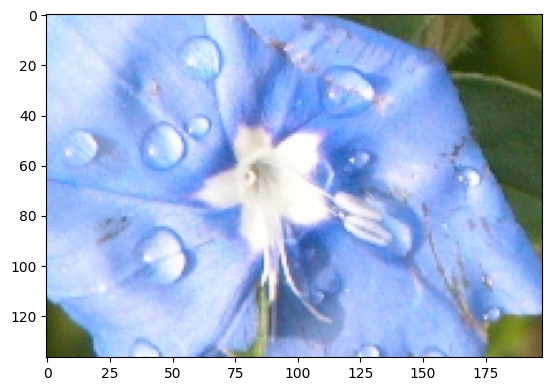

In [8]:
# 데이터셋 load 및 확인
img_paths = glob(path + '/' + '*.png')

img = cv2.imread(img_paths[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)

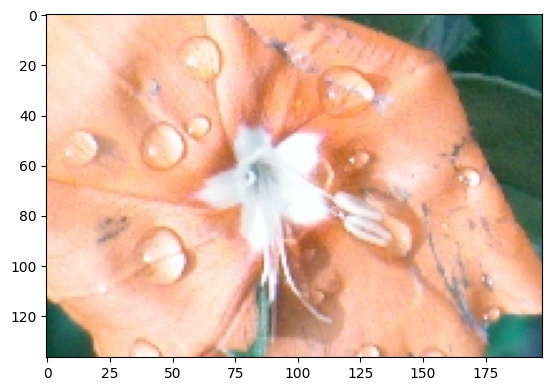

In [9]:
img = cv2.imread(img_paths[0], cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [10]:
# 저해상도 이미지 만들기
# srcnn의 학습은 저해상도 이미지와 고해상도 이미지를 각각 sub images로 crop하고
# 이들간의 관계를 학습

# 즉, crop -> mapping

In [11]:
sub_lr_images = []
sub_hr_images = []

for img_path in img_paths:
    img = cv2.imread(img_path, cv2.COLOR_BGR2RGB)

# mod crop
h = img.shape[0] - np.mod(img.shape[0], upscale_factor)
w = img.shape[1] - np.mod(img.shape[1], upscale_factor)
img = img[0:h, 0:w, :]

# zoom_img
label = img.astype('float')/ 255
# temp_input = cv2.resize(label, (input_size, input_size), interpolation=cv2.INTER_CUBIC)
temp_input = cv2.resize(label,dsize=(0,0),fx=1/upscale_factor,
                        fy=1/upscale_factor,interpolation=cv2.INTER_AREA)
input = cv2.resize(temp_input, dsize=(0,0),fx=upscale_factor,
                        fy=upscale_factor, interpolation=cv2.INTER_CUBIC)

# crop : img to sub_imgs
for h in range(0, input.shape[0] - input_size + 1, stride):
    for w in range(0, input.shape[1] - input_size + 1, stride):
        sub_lr_img = input[h:h+input_size, w:w+input_size, :]
        sub_hr_img = label[h+pad:h+pad+output_size, w+pad:w+pad+output_size, :]

        sub_lr_images.append(sub_lr_img)
        sub_hr_images.append(sub_hr_img)

sub_lr_imgs = np.array(sub_lr_images)
sub_hr_imgs = np.array(sub_hr_images)

In [12]:
# crop된 저해상도, 고해상도 paired 이미지 확인

76


Text(0.5, 1.0, 'sub_hr_imgs')

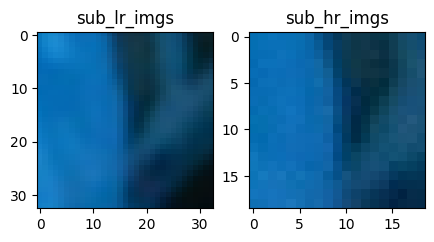

In [13]:
fig, axes = plt.subplots(1,2, figsize=(5,5))
# idx = random.randint(0, sub_lr_imgs.shape[0]-1)
idx = random.randint(0, sub_lr_imgs.shape[0])

axes[0].imshow(sub_lr_imgs[idx])
axes[1].imshow(sub_hr_imgs[idx])

print(idx)
axes[0].set_title('sub_lr_imgs')
axes[1].set_title('sub_hr_imgs')

## 고 : 픽셀 수가 많아서 이미지를 확대해도 픽셀이 눈에 잘 띄지 않고, 디테일이 잘 보존
###사진, 영상, 그래픽 등에서 고해상도는 선명하고 깨끗한 이미지를 제공

## 저 : 픽셀 수가 적어서 이미지를 확대하면 픽셀이 눈에 잘 띄고, 디테일이 부족
###저해상도는 이미지가 흐릿하게 보일 수 있으며, 세부사항이 잘 드러나지 않음

In [14]:
# 모델 선언 및 파라미터 초기화

### GloroNormal은 Xaiver 정규분포를 의미

In [15]:
initializer = initializers.GlorotNormal()

SRCNN = Sequential()
# SRCNN.add(Input(shpae=(33,33,3)))
SRCNN.add(Conv2D(filters=n1, kernel_size=f1, activation='relu',
                 input_shape=(33,33,3), kernel_initializer=initializer,
                 bias_initializer='zeros', name='conv1'))
SRCNN.add(Conv2D(filters=n2, kernel_size=f2, activation='relu',
                 kernel_initializer=initializer, bias_initializer='zeros', name='conv2'))
SRCNN.add(Conv2D(filters=n3, kernel_size=f3, activation='linear',
                 kernel_initializer=initializer, bias_initializer='zeros', name='conv3'))

print(SRCNN.summary())

## < SRCNN Model 구조 >

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                       │ (None, 25, 25, 128)         │          31,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 23, 23, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 19, 19, 3)           │           4,803 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109,827 (429.01 KB)

 Trainable params: 109,827 (429.01 KB)

 Non-trainable params: 0 (0.00 B)

None


In [16]:
# model compile or fit

## epoch을 몇 번 돌려볼까?
## 기존 코드에서 숫자만 바꿔서 더 돌려볼까?? (cell-11)

In [17]:
optimizer = Adam(learning_rate=0.0003)
SRCNN.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

In [18]:
SRCNN.fit(sub_lr_imgs, sub_hr_imgs, batch_size=batch_size,
          epochs=epochs, verbose=1, # callbacks=[callbacks]
          )

## callbacks를 넣는 이유?

## callbacks가 애초에 전과정에서 변수로 지정이 되어야 하는데 어디서 지정?

Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 0.1759 - mean_squared_error: 0.1759
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 0.0264 - mean_squared_error: 0.0264
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.0130 - mean_squared_error: 0.0130
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 0.0136 - mean_squared_error: 0.0136
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 9/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 10/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 11/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 0.0030 - mean_s

In [19]:
# 성능 확인을 위한 test model 선언

In [21]:
initializer = initializers.GlorotNormal()

def predict_model():
    SRCNN = Sequential()
    SRCNN.add(Conv2D(filters=n1, kernel_size=f1, activation='relu',
                     input_shape=(None, None,3), kernel_initializer=initializer, bias_initializer='zeros',
                     name='Conv1'))
    SRCNN.add(Conv2D(filters=n2, kernel_size=f2, activation='relu',
                     kernel_initializer=initializer, bias_initializer='zeros',
                     name='Conv2'))
    SRCNN.add(Conv2D(filters=n3, kernel_size=f3, activation='linear',
                     kernel_initializer=initializer, bias_initializer='zeros',
                     name='Conv3'))
    return SRCNN




In [42]:
#
SRCNN_Test = predict_model()
# 모델 가중치를 .weights.h5 형식으로 저장
save_path = '/content/drive/MyDrive/srcnn/Set5.weights.h5'
SRCNN_Test.save_weights(save_path)

# 모델 가중치를 .weights.h5 형식으로 로드
save_path = '/content/drive/MyDrive/srcnn/Set5.weights.h5'
SRCNN_Test.load_weights(save_path)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
# 이미지 비교
# Set5 에서 그림 선택(butterfly)
## bicubic으로 upscaling된 이미지는 모델학습 과정과 동일하게 처리해서 만들어준다.

In [45]:
import cv2

# 이미지 읽기
hr_img_path = '/content/drive/MyDrive/srcnn/Set5/Set5/butterfly.png'
hr_img = cv2.imread(hr_img_path)

# 이미지가 제대로 읽혔는지 확인
if hr_img is None:
    raise ValueError(f"Image not loaded. Check the file path or file format: {hr_img_path}")



In [46]:
# 이미지 색상 변환
hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB)
print('img shape :{}'.format(hr_img.shape))

img shape :(256, 256, 3)


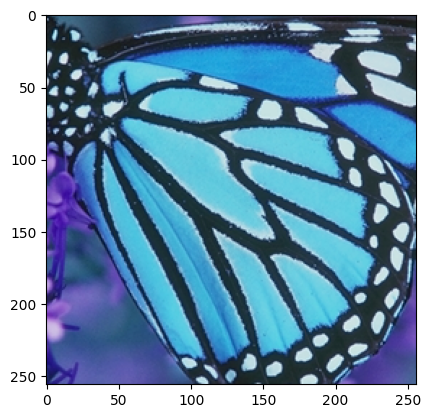

In [48]:
plt.imshow(hr_img)

In [49]:
hr_img = hr_img.astype('float')/255
temp_img = cv2.resize(hr_img, dsize=(0,0), fx=1/upscale_factor, fy=1/upscale_factor,
                      interpolation=cv2.INTER_AREA)
bicubic_img = cv2.resize(temp_img, dsize=(0,0), fx=upscale_factor, fy=upscale_factor,
                         interpolation=cv2.INTER_CUBIC)

input_img = bicubic_img[np.newaxis, :]
srcnn_img = SRCNN_Test.predict(input_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step


In [ ]:
# 3개 이미지를 한눈에 비교

Text(0.5, 1.0, 'srcnn_img')

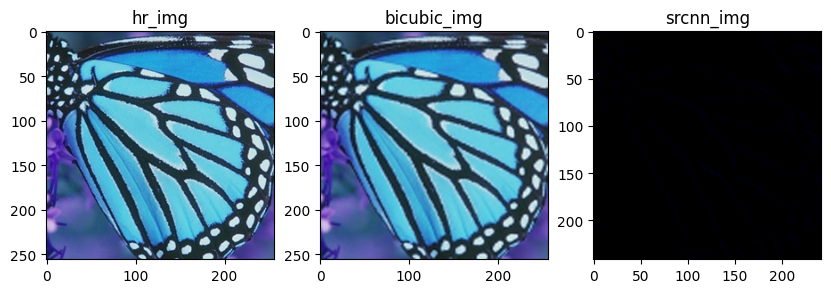

In [50]:
fig, axes = plt.subplots(1,3,figsize=(10,5))

axes[0].imshow(hr_img)
axes[1].imshow(bicubic_img)
axes[2].imshow(np.squeeze(srcnn_img))

axes[0].set_title('hr_img')
axes[1].set_title('bicubic_img')
axes[2].set_title('srcnn_img')

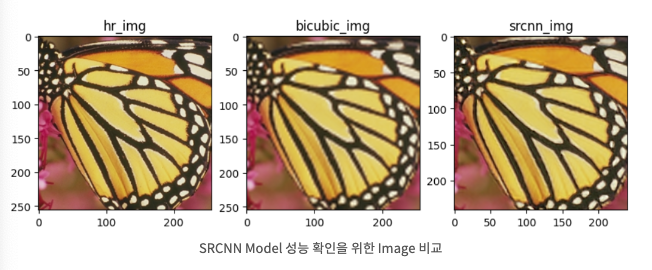